**Installing the neccessary Libiraries**

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter
import yaml
import pandas as pd
import seaborn as sns

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:00


In [ ]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 104.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


**Logging in to roboflow to get the data**

In [ ]:
!roboflow login

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: 


**Downloading the dataset in Yolov8 Version**

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="iat9Ga5MhIGk4XN5gjuc")
project = rf.workspace("hambuta").project("yolo-v8-vlktd-pydak")
version = project.version(1)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to YOLO-v8-1 in yolov8:: 100%|██████████| 2012/2012 [00:00<00:00, 10206.27it/s]


**Some EDA**

In [ ]:
with open("/content/YOLO-v8-1/data.yaml", "r") as f:
    data = yaml.safe_load(f)

CLASS_NAMES = data["names"]
NUM_CLASSES = len(CLASS_NAMES)

train_img_dir = data["train"].replace("..", "/content/YOLO-v8-1")
train_lbl_dir = train_img_dir.replace("images", "labels")

train_images = [f for f in os.listdir(train_img_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
print("Total training images:", len(train_images))


Total training images: 700


In [ ]:
with open("/content/YOLO-v8-1/data.yaml", "r") as f:
    data = yaml.safe_load(f)

CLASS_NAMES = data["names"]
NUM_CLASSES = len(CLASS_NAMES)

valid_img_dir = data["val"].replace("..", "/content/YOLO-v8-1")
valid_lbl_dir = valid_img_dir.replace("images", "labels")

valid_images = [f for f in os.listdir(valid_img_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
print("Total validation images:", len(valid_images))

Total training images: 200


In [ ]:
with open("/content/YOLO-v8-1/data.yaml", "r") as f:
    data = yaml.safe_load(f)

CLASS_NAMES = data["names"]
NUM_CLASSES = len(CLASS_NAMES)

test_img_dir = data["test"].replace("..", "/content/YOLO-v8-1")
test_lbl_dir = test_img_dir.replace("images", "labels")

test_images = [f for f in os.listdir(test_img_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
print("Total testing images:", len(test_images))

Total testing images: 100


In [ ]:
class_counts = Counter()

for lbl_file in os.listdir(train_lbl_dir):
    if lbl_file.endswith(".txt"):
        with open(os.path.join(train_lbl_dir, lbl_file), "r") as f:
            for line in f.readlines():
                class_id = int(line.split()[0])
                class_counts[class_id] += 1

In [ ]:
df = pd.DataFrame([
    {"class_id": cid, "class_name": CLASS_NAMES[cid], "count": cnt}
    for cid, cnt in class_counts.items()
])

print(df)

   class_id class_name  count
0         2        cow    135
1         7     person    155
2         5       goat    114
3         0        cat     85
4         6      horse    118
5         3        dog    101
6         8     racoon     80
7         1    chicken    148
8         4        fox     79
9         9      skunk     66


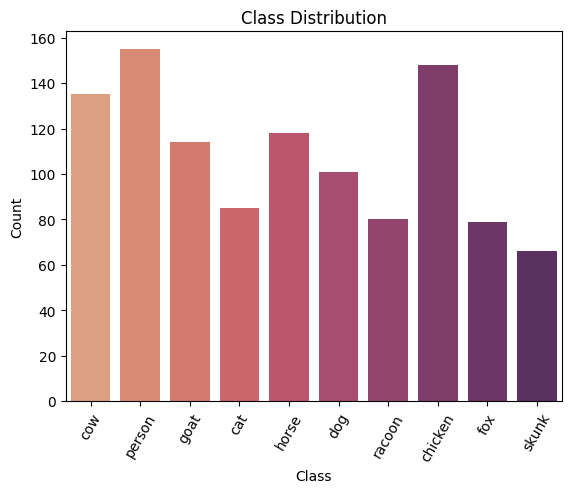

In [ ]:
sns.barplot(data= df, x= 'class_name', y= 'count', palette= 'flare', hue= 'class_name', legend= False)
plt.xticks(rotation= 60)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

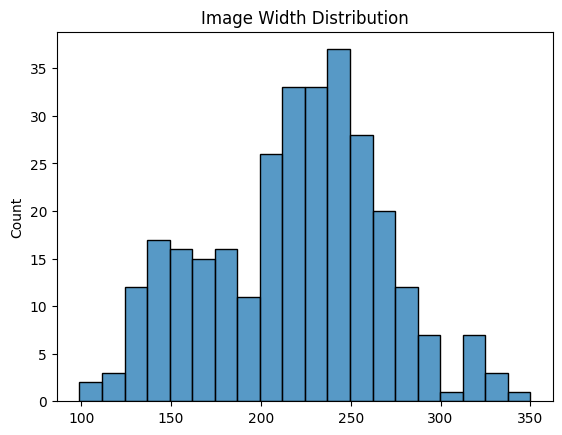

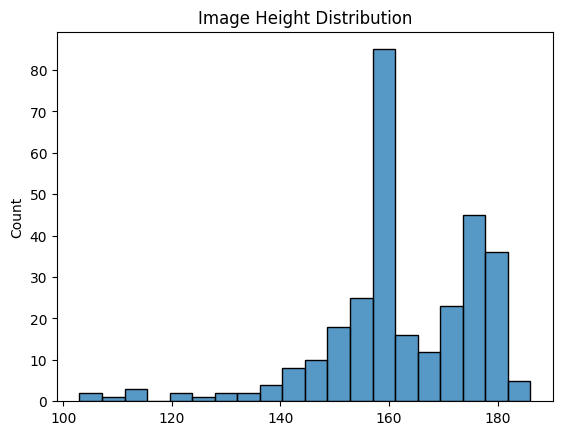

In [ ]:
widths, heights = [], []
for img_name in train_images[:300]:
    img = cv2.imread(os.path.join(train_img_dir, img_name))
    h, w = img.shape[:2]
    widths.append(w)
    heights.append(h)

sns.histplot(widths, bins=20)
plt.title("Image Width Distribution")
plt.show()

sns.histplot(heights, bins=20)
plt.title("Image Height Distribution")
plt.show()

**Initializing the model**

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8m.pt")

**Training the model 100 Epochs**

In [ ]:
model.train(data="/content/YOLO-v8-1/data.yaml",
    epochs=100,
    imgsz=640,
    batch=16,
    device=0,
    augment=True,
    mosaic=True,
    mixup=True,
    cache=True,
    name="animal_yolo_exp")

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/YOLO-v8-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=True, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=True, multi_scale=False, name=animal_yolo_exp, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79e0f4a51640>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

**Validation**

In [ ]:
metrics = model.val()
print(metrics)

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 172.2±157.0 MB/s, size: 9.2 KB)
val: Scanning /content/YOLO-v8-1/valid/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 200/200 398.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 2.7it/s 4.9s
                   all        200        351      0.895      0.804      0.886      0.685
                   cat         18         18      0.939      0.857      0.972      0.717
               chicken         18         51      0.976      0.667      0.801      0.542
                   cow         23         51      0.807      0.588      0.734      0.524
                   dog         24         26      0.873      0.808      0.868      0.724
                   fox         20         21      0.857      0.905       0.94      0.827
                  goat         18      

**Trying the model (Model Downloaded and saved)**


image 1/1 /content/YOLO-v8-1/test/images/366_jpg.rf.519ebb0144cbb714f06a443ce5a20142.jpg: 640x608 1 cow, 37.3ms
Speed: 2.5ms preprocess, 37.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


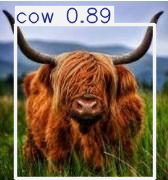

In [ ]:
from ultralytics import YOLO

# Load model
model = YOLO("/content/runs/detect/animal_yolo_exp/weights/best.pt")

# Run inference
results = model("/content/YOLO-v8-1/test/images/366_jpg.rf.519ebb0144cbb714f06a443ce5a20142.jpg")  # single image
results[0].show()
